## SentiMoji

In [ ]:
"""
Pipeline code for training and evaluating the sentiment classifier.
We use the Deepmoji architecture here, see https://github.com/bfelbo/DeepMoji for detail.
"""
import re
import codecs
import random
import numpy as np
import sys
import json
import argparse
import pandas as pd
import glob, os
import matplotlib.pylab as plt

sys.path.append("DeepMoji/deepmoji/")

from sentence_tokenizer import SentenceTokenizer
from model_def import deepmoji_architecture, load_specific_weights
from finetuning import load_benchmark, finetune

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

MAX_LEN = 150

import tensorflow as tf
tf.get_logger().setLevel('INFO')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
if __name__ == "__main__":
    print("========== Starting processing =========")
    parser = argparse.ArgumentParser()

    parser.add_argument("--model", type=str, required=True, choices=["SEntiMoji", "SEntiMoji-T", "SEntiMoji-G"], help="name of pretrained representation model")
    parser.add_argument("--task", type=str.lower, required=True, choices=["sentiment", "emotion"], help="specify task (sentiment or emotion)")
    parser.add_argument("--benchmark_dataset_name", type=str, required=False, choices=["Jira", "StackOverflow", "CodeReview", "JavaLib"], help="name of benchmark dataset")
    parser.add_argument("--emotion_type", type=str.lower, required=False, default=None, choices=["anger", "love", "deva", "joy", "sad"], help="specify emotion dataset")
    
    parser.add_argument("--use_own_dataset", action='store_true', help="whether use your own dataset or not")
    parser.add_argument("--own_dataset_dir", type=str, required=False, default=None, help="directory of your train data file")
    parser.add_argument("--own_dataset_file", type=str, required=False, default=None, help="file name of your train data file")
    parser.add_argument("--cross_platform", action='store_true', help="This will load code to run against cross platform dataset")

    # args = parser.parse_args()
    args = parser.parse_args(['--model', 'SEntiMoji', '--task', 'sentiment'])

    print("args:")
    d = args.__dict__
    for key,value in d.items():
        print("%s = %s"%(key,value))

    # parse arguments
    model_path = "../../model/representation_model/model_%s.hdf5" % args.model
    vocab_path = "vocabulary/vocabulary_%s.json" % args.model
    out_dir = "../../output/out/"
    base_dir = "/home/mdabdullahal.alamin/alamin/sentiment/sentimoji"

    # load vocabulary 
    with open(vocab_path, "r") as f_vocab:
        vocabulary = json.load(f_vocab)


    label2index = {"0": 0, "1": 1, "-1": 2}
    index2label = {i: l for l, i in label2index.items()}

    # sentence tokenizer (MAXLEN means the max length of input text)
    st = SentenceTokenizer(vocabulary, MAX_LEN)
    fold = 0

    # datasets = ["DatasetSenti4SDSO", "OrtuJIRA", "GitHub"]
    # datasets = ["OrtuJIRA", "GitHub"]
    datasets = ["DatasetSenti4SDSO"]


    # datasets = ["DatasetSenti4SDSO"]
    input_file ="/home/mdabdullahal.alamin/alamin/sentiment/cross_platform/final_output/combined.csv"

    
    test_type = "inner_platform" # test_type can be inner_platform or cross platform
    # test_type = "cross_platform"
    # test_type = "both"

========== Starting processing =========
args:
model = SEntiMoji
task = sentiment
benchmark_dataset_name = None
emotion_type = None
use_own_dataset = False
own_dataset_dir = None
own_dataset_file = None
cross_platform = False


In [ ]:
from sklearn.model_selection import train_test_split

def get_fixed_test_split(infile, dataset):
  dataset = dataset.lower()
  df_all = pd.read_csv(input_file, usecols=['id', 'dataset', 'text', 'oracle'], dtype={'oracle': str})
  df_all = df_all[['id', 'text', 'oracle', 'dataset']]
  print("len(df_all) %d" % len(df_all))

  dataset_df = df_all[df_all['dataset'].astype(str).str.lower().str.contains(dataset)]
  print("lenght of the dataset %s is : %d"% (dataset, len(dataset_df)))
    
  # X = dataset_df[['id', 'text']]
  X = dataset_df['text']
  y = dataset_df['oracle']
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=0, stratify=y)
  
  return X_train, X_test, y_train, y_test

  
def get_train_test_by_size(sample_size, X_train_remain, y_train_remain, X_train_prev, y_train_prev):
  X = X_train_remain
  y = y_train_remain
  
  try:
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=sample_size, random_state=0, stratify=y)
  except ValueError as e:
    # print(e)
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=sample_size, random_state=0)

  if len(X_train_prev) != 0:
    X_train = X_train_prev.append(X_train)
    y_train = y_train_prev.append(y_train)
  return X_train, y_train, X_test, y_test


def get_train_test(itr_no, sample_size, X_train_remain, y_train_remain):
  X_train_prev = []
  y_train_prev = []

  for itr in range(itr_no):
    X_train_prev, y_train_prev, X_train_remain, y_train_remain =  get_train_test_by_size(sample_size, X_train_remain, y_train_remain, X_train_prev, y_train_prev)
  
  return X_train_prev, y_train_prev

In [ ]:
if(test_type == "inner_platform" or test_type == "both"):
  print("============ Inner platform train test ==========")
  for dataset in datasets:
    dataset = dataset.lower()
    print(f'Dataset: {dataset}')
    X_train, X_test, y_train, y_test = get_fixed_test_split(infile=input_file, dataset = dataset)
    sample_size = int((len(X_train)+len(X_test))* 0.05)
    print(f'Sample Size: {sample_size}')
    for itr in range(14, 15):
      print("*****************************************")
      print("Iteration: %d" % itr)

      train_text, train_label = get_train_test(itr, sample_size, X_train, y_train)
      test_text, test_label = X_test, y_test

      # train_id, train_text, train_label, test_id, test_text, test_label = get_train_test(infile=input_file, dataset = dataset, fold=fold)
      # print(type(train_text[0]))
      # print("len train: %d and len test %d"%(len(train_id), len(test_id)))
      train_X, _, _ = st.tokenize_sentences(train_text)
      test_X, _, _ = st.tokenize_sentences(test_text)
      train_y = np.array([label2index[l] for l in train_label])
      test_y = np.array([label2index[l] for l in test_label])

      nb_classes = len(label2index)
      nb_tokens = len(vocabulary)

      # use 20% of the training set for validation
      train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                      test_size=0.2, random_state=0)
      # # model 
      model = deepmoji_architecture(nb_classes=nb_classes,
                                  nb_tokens=nb_tokens,
                                  maxlen=MAX_LEN, embed_dropout_rate=0.25, final_dropout_rate=0.5, embed_l2=1E-6)
      if itr == 1 :
        model.summary()

      # # load pretrained representation model
      load_specific_weights(model, model_path, nb_tokens, MAX_LEN,
                          exclude_names=["softmax"])
      # 
      # # train model
      model, acc = finetune(model, [train_X, val_X, test_X], [train_y, val_y, test_y], nb_classes, 100,
                          method="chain-thaw", verbose=0)

      
      pred_y_prob = model.predict(test_X)

      if nb_classes == 2:
          pred_y = [0 if p < 0.5 else 1 for p in pred_y_prob]
      else:
          pred_y = np.argmax(pred_y_prob, axis=1)

      # evaluation
      accuracy = accuracy_score(test_y, pred_y)
      precision_micro = precision_score(test_y, pred_y, average = 'micro')
      precision_macro = precision_score(test_y, pred_y, average = 'macro')
      recall_micro = recall_score(test_y, pred_y, average = 'micro')
      recall_macro = recall_score(test_y, pred_y, average = 'macro')
      f1score_micro = f1_score(test_y, pred_y, average = 'micro')
      f1score_macro = f1_score(test_y, pred_y, average = 'macro')
      print("Accuracy: %.3f, Precision (Macro): %.3f, Recall (Macro): %.3f, F1 score (Micro): %.3f, F1 score (Macro): %.3f" % (accuracy, precision_macro, recall_macro, f1score_micro, f1score_macro))

      result = pd.DataFrame(
          [{'iteration':itr, 'accuracy': accuracy, 'precision_micro': precision_micro, 'precision_macro': precision_macro, 
            'recall_micro': recall_micro, 'recall_macro': recall_macro, 'f1_micro':f1score_micro, 'f1_macro': f1score_macro}])
      if itr == 1:
        result.to_csv(f'{out_dir}/{dataset}_learning_curve.csv', index=False)
      else:
        result.to_csv(f'{out_dir}/{dataset}_learning_curve.csv', index=False, mode='a', header=False)

      # precision = precision_score(test_y, pred_y, average=None)
      # recall = recall_score(test_y, pred_y, average=None)
      # f1score = f1_score(test_y, pred_y, average=None)
      # labels = list(set(test_y))
      # precision = precision_score(test_y, pred_y, average=None, labels = labels)
      # recall = recall_score(test_y, pred_y, average=None, labels = labels)
      # f1score = f1_score(test_y, pred_y, average=None, labels = labels)

      # for index in range(0, len(labels)):
      #     print("label: %s" % index2label[index])
      #     print("Precision: %.3f, Recall: %.3f, F1 score: %.3f" % (precision[index], recall[index], f1score[index]))
      print("*****************************************")

      # save predict result

      # save_name = "sentimoji_%s_%d.csv" % ( dataset, fold)        
      # save_name = os.path.join(out_dir, save_name)
      # if(not os.path.exists(save_name)):
      #     os.makedirs(save_name)
      # with open(save_name, "w", encoding="utf-8") as f:
      #     for i in range(0, len(test_text)):
      #         f.write("%s,%s\r\n" % (test_id[i], index2label[pred_y[i]]))
      # print("#%d test results has been saved to: %s" % (len(test_text), save_name))
      # fold += 1
      # output_dir = "../../model/trained_model" + str(fold) + ".h5"
      # break
      # break

print("========== Finished processing =========")


============ Inner platform train test ==========
Dataset: datasetsenti4sdso
len(df_all) 17414
lenght of the dataset datasetsenti4sdso is : 4423
Sample Size: 221
*****************************************
Iteration: 14
../../model/representation_model/model_SEntiMoji.hdf5
Accuracy: 0.868, Precision (Macro): 0.866, Recall (Macro): 0.867, F1 score (Micro): 0.868, F1 score (Macro): 0.867
*****************************************
========== Finished processing =========


## BERT4SentiSE

In [ ]:
%pwd

'/home/mdabdullahal.alamin/alamin/sentiment/bert/code'

In [ ]:
%cd /home/mdabdullahal.alamin/alamin/sentiment/bert/code/

/home/mdabdullahal.alamin/alamin/sentiment/bert/code


In [ ]:
import csv
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import shutil
import run_sosc
import argparse
from pathlib import Path
import shutil
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import sys
import sys
sys.argv = sys.argv[:1]
# sys.argv = ['--do_train']
from run_sosc import *

from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if __name__ == "__main__":
    ######Configuration for running BERT 10 fold ########
    # print("argument parser commented out")
    tf.get_logger().setLevel(logging.ERROR)

    root_dir = os.getcwd()
    ###Temporary directory for saving BERT results###
    source_dir = os.path.join(root_dir, 'sosc_output')
    out_dir = "/home/mdabdullahal.alamin/alamin/sentiment/bert/output/out/"
    num_of_folds = 10
    undersample = 'no' #provide yes or no
    data_dir = "/home/mdabdullahal.alamin/alamin/sentiment/bert/dataset"

    datasets = ["DatasetSenti4SDSO", "OrtuJIRA", "GitHub"]
    # datasets = ["DatasetSenti4SDSO"]

    input_file = "/home/mdabdullahal.alamin/alamin/sentiment/cross_platform/final_output/combined.csv"

    test_type = "inner_platform" # test_type can be inner_platform or cross platform
    # test_type = "cross_platform"
    # test_type = "both"

In [ ]:
from sklearn.model_selection import train_test_split

def get_fixed_test_split(infile, dataset):
  dataset = dataset.lower()
  df_all = pd.read_csv(input_file, skiprows=1, names=['id', 'dataset', 'text', 'oracle'], dtype={'oracle': str})
  df_all = df_all[['id', 'text', 'oracle', 'dataset']]
  df_all.loc[df_all.oracle == '0', 'oracle'] = 'Neutral'
  df_all.loc[df_all.oracle == '-1', 'oracle'] = 'Negative'
  df_all.loc[df_all.oracle == '1', 'oracle'] = 'Positive'

  dataset_df = df_all[df_all['dataset'].astype(str).str.lower().str.contains(dataset)]
  print("lenght of the dataset %s is : %d"% (dataset, len(dataset_df)))
    
  X = dataset_df[['id', 'text']]
  # X = dataset_df['text']
  y = dataset_df['oracle']
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=0, stratify=y)
  
  test_df = pd.concat([X_test, y_test], axis=1)
  test_df.to_csv(data_dir + "/test.tsv", sep='\t', index=False, header = None, )

  sample_size = int((len(X_train)+len(X_test))* 0.05)
  return X_train, y_train, X_test, y_test, sample_size

  
def get_train_test_by_size(sample_size, X_train_remain, y_train_remain, X_train_prev, y_train_prev):
  X = X_train_remain
  y = y_train_remain
  
  try:
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=sample_size, random_state=0, stratify=y)
  except ValueError as e:
    # print(e)
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=sample_size, random_state=0)

  if len(X_train_prev) != 0:
    X_train = X_train_prev.append(X_train)
    y_train = y_train_prev.append(y_train)
  return X_train, y_train, X_test, y_test


def get_train_test(itr_no, sample_size, X_train_remain, y_train_remain):
  X_train_prev = []
  y_train_prev = []

  for itr in range(itr_no):
    X_train_prev, y_train_prev, X_train_remain, y_train_remain =  get_train_test_by_size(sample_size, X_train_remain, y_train_remain, X_train_prev, y_train_prev)
  
  train_df = pd.concat([X_train_prev, y_train_prev], axis=1)
  train_df.to_csv( data_dir + "/train.tsv", sep='\t', index=False, header = None)

In [ ]:
if(test_type == "inner_platform" or test_type=="both"):
  for dataset in datasets:
    dataset = dataset.lower()            
    print(f'Dataset: {dataset}')
    X_train, y_train, X_test, y_test, sample_size = get_fixed_test_split(infile=input_file, dataset = dataset)
    print(f'Sample Size: {sample_size}')

Dataset: datasetsenti4sdso
lenght of the dataset datasetsenti4sdso is : 4423
Sample Size: 221
Dataset: ortujira
lenght of the dataset ortujira is : 5869
Sample Size: 293
Dataset: github
lenght of the dataset github is : 7122
Sample Size: 356


In [ ]:
if(test_type == "inner_platform" or test_type=="both"):
  for dataset in datasets:
    dataset = dataset.lower()            
    print(f'Dataset: {dataset}')
    X_train, y_train, X_test, y_test, sample_size = get_fixed_test_split(infile=input_file, dataset = dataset)
    print(f'Sample Size: {sample_size}')
    for itr in range(1, 15):
      print("*****************************************")
      print("Iteration: %d" % itr)

      get_train_test(itr, sample_size, X_train, y_train)

      # print("\n ==================> Dataset %s and Fold: %s "% (dataset, str(fold)))
      # dest_file_name = 'bert_' + dataset + "_" + str(fold) + ".csv"                
      # des_dir = os.path.join(out_dir, "inner")
      # dest_file = os.path.join(des_dir, dest_file_name)
      # if(not os.path.exists(des_dir)):
      #     os.makedirs(des_dir)
      # disa_create_train_test_set(input_file=input_file, dataset=dataset, fold=fold)
      
      pred_y = run_sosc.main()
      # dest = shutil.move(source_dir, des_dir, copy_function = shutil.copytree)
      # shutil.copy2('sosc_output/test_results.csv', dest_file)
      # print("=========> Result has been copied to %s" % (dest_file))
      # evaluation

      test_y = y_test
      accuracy = accuracy_score(test_y, pred_y)
      precision_micro = precision_score(test_y, pred_y, average = 'micro')
      precision_macro = precision_score(test_y, pred_y, average = 'macro')
      recall_micro = recall_score(test_y, pred_y, average = 'micro')
      recall_macro = recall_score(test_y, pred_y, average = 'macro')
      f1score_micro = f1_score(test_y, pred_y, average = 'micro')
      f1score_macro = f1_score(test_y, pred_y, average = 'macro')
      print("Accuracy: %.3f, Precision (Macro): %.3f, Recall (Macro): %.3f, F1 score (Micro): %.3f, F1 score (Macro): %.3f" % (accuracy, precision_macro, recall_macro, f1score_micro, f1score_macro))

      result = pd.DataFrame(
          [{'iteration':itr, 'accuracy': accuracy, 'precision_micro': precision_micro, 'precision_macro': precision_macro, 
            'recall_micro': recall_micro, 'recall_macro': recall_macro, 'f1_micro':f1score_micro, 'f1_macro': f1score_macro}])
      if itr == 1:
        result.to_csv(f'{out_dir}/{dataset}_learning_curve.csv', index=False)
      else:
        result.to_csv(f'{out_dir}/{dataset}_learning_curve.csv', index=False, mode='a', header=False)

      shutil.rmtree("sosc_output/", ignore_errors=True)
   

### Twitter

In [ ]:
if __name__ == "__main__":
    tf.get_logger().setLevel(logging.ERROR)
    root_dir = os.getcwd()
    ###Temporary directory for saving BERT results###
    source_dir = os.path.join(root_dir, 'sosc_output')
    out_dir = "/home/mdabdullahal.alamin/alamin/sentiment/bert/output/out/"
    num_of_folds = 10
    undersample = 'no' #provide yes or no
    data_dir = "/home/mdabdullahal.alamin/alamin/sentiment/bert/dataset"

    datasets = ["DatasetSenti4SDSO", "OrtuJIRA", "GitHub"]
    # datasets = ["DatasetSenti4SDSO"]

    train_file = data_dir + '/Tweets.csv'
    test_file = "/home/mdabdullahal.alamin/alamin/sentiment/cross_platform/final_output/combined.csv"
    

    # test_type = "inner_platform" # test_type can be inner_platform or cross platform
    # test_type = "cross_platform"
    # test_type = "both"

In [ ]:
def get_train_test(train_file, test_file):
  df_all = pd.read_csv(train_file)
  df_all = df_all[['tweet_id', 'text', 'airline_sentiment']].rename(columns={'tweet_id': 'id', 'airline_sentiment':'oracle'})
  df_all.loc[df_all.oracle == 'neutral', 'oracle'] = 'Neutral'
  df_all.loc[df_all.oracle == 'negative', 'oracle'] = 'Negative'
  df_all.loc[df_all.oracle == 'positive', 'oracle'] = 'Positive'
  df_all = df_all.replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n',  ' ', regex=True)
  train_df = df_all
  
  df_all = pd.read_csv(test_file, skiprows=1, names=['id', 'dataset', 'text', 'oracle'], dtype={'oracle': str})
  df_all = df_all[['id', 'text', 'oracle']]
  df_all.loc[df_all.oracle == '0', 'oracle'] = 'Neutral'
  df_all.loc[df_all.oracle == '-1', 'oracle'] = 'Negative'
  df_all.loc[df_all.oracle == '1', 'oracle'] = 'Positive'
  test_df = df_all

  print("lenght of the training dataset is : %d"% (len(train_df)))  
  print("lenght of the testing dataset is : %d"% (len(test_df)))  
  train_df.to_csv( data_dir + "/train.tsv", sep='\t', index=False, header = None)#, escapechar='\\', quoting=csv.QUOTE_NONNUMERIC)
  test_df.to_csv(data_dir + "/test.tsv", sep='\t', index=False, header = None)#, escapechar='\\', quoting=csv.QUOTE_NONNUMERIC)


In [ ]:
get_train_test(train_file, test_file)
dest_file_name = 'bert_tweeter.csv'
dest_file = os.path.join(out_dir, dest_file_name)
des_dir = out_dir
if(not os.path.exists(des_dir)):
  os.makedirs(des_dir)

pred_y = run_sosc.main()
dest = shutil.move(source_dir, des_dir, copy_function = shutil.copytree)
shutil.copy2('sosc_output/test_results.csv', dest_file)
print("=========> Result has been copied to %s" % (dest_file))
shutil.rmtree("sosc_output/", ignore_errors=True)
   

lenght of the training dataset is : 14640
lenght of the testing dataset is : 17414
Alamin: Going to start training
***** Running prediction*****
sosc_output/test_results.csv
***** Predict results: UID => oracle => prediction => individual probabilities *****


FileNotFoundError: ignored

#### Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
datasets = ["DatasetSenti4SDSO", "OrtuJIRA", "GitHub"]

# dataset = datasets[0]
input_file = "/home/mdabdullahal.alamin/alamin/sentiment/cross_platform/final_output/combined.csv"
pred_file = '/home/mdabdullahal.alamin/alamin/sentiment/bert/output/out/twitter_cross_platform.csv' ### UPDATE when changed or rerunned

def calc_metrics(dataset):
  print(f'Dataset: {dataset}')
  dataset = dataset.lower()
  df_all = pd.read_csv(input_file, usecols=['id', 'dataset', 'text', 'oracle'], dtype={'oracle': str})
  df_all = df_all[['id', 'text', 'oracle', 'dataset']]
  df_all.loc[df_all.oracle == '0', 'oracle'] = 'Neutral'
  df_all.loc[df_all.oracle == '-1', 'oracle'] = 'Negative'
  df_all.loc[df_all.oracle == '1', 'oracle'] = 'Positive'
  dataset_df = df_all[df_all['dataset'].astype(str).str.lower().str.contains(dataset)]

  df_pred = pd.read_csv(pred_file, header=None, names=['id','oracle'], dtype={'oracle': str})
  dataset_pred = df_pred[df_pred.id.isin(dataset_df.id)]

  test_y = dataset_df['oracle']
  pred_y = dataset_pred['oracle']
  accuracy = accuracy_score(test_y, pred_y)
  precision_micro = precision_score(test_y, pred_y, average = 'micro')
  precision_macro = precision_score(test_y, pred_y, average = 'macro')
  recall_micro = recall_score(test_y, pred_y, average = 'micro')
  recall_macro = recall_score(test_y, pred_y, average = 'macro')
  f1score_micro = f1_score(test_y, pred_y, average = 'micro')
  f1score_macro = f1_score(test_y, pred_y, average = 'macro')
  print("Accuracy: %.3f, Precision (Macro): %.3f, Recall (Macro): %.3f, F1 score (Micro): %.3f, F1 score (Macro): %.3f" % (accuracy, precision_macro, recall_macro, f1score_micro, f1score_macro))

for dataset in datasets:
  calc_metrics(dataset)

Dataset: DatasetSenti4SDSO
Accuracy: 0.649, Precision (Macro): 0.729, Recall (Macro): 0.679, F1 score (Micro): 0.649, F1 score (Macro): 0.652
Dataset: OrtuJIRA
Accuracy: 0.554, Precision (Macro): 0.607, Recall (Macro): 0.676, F1 score (Micro): 0.554, F1 score (Macro): 0.567
Dataset: GitHub
Accuracy: 0.509, Precision (Macro): 0.641, Recall (Macro): 0.547, F1 score (Micro): 0.509, F1 score (Macro): 0.514


## Graphs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
moji_dir = '/home/mdabdullahal.alamin/alamin/sentiment/sentimoji/output/out'
bert_dir = '/home/mdabdullahal.alamin/alamin/sentiment/bert/output/out'
fig_dir = '/home/mdabdullahal.alamin/alamin/sentiment/res'
FIG_EXT = '.pdf'
file_github = '/github_learning_curve.csv'
file_so = '/datasetsenti4sdso_learning_curve.csv'
file_jira = '/ortujira_learning_curve.csv'
itr_github = 356
itr_so = 221
itr_jira = 293

In [ ]:
github_moji = pd.read_csv(moji_dir + file_github)
github_bert = pd.read_csv(bert_dir + file_github)

In [ ]:
columns = ['iteration', 'f1_macro']
temp = github_moji[columns].join(github_bert[columns], lsuffix='_moji', rsuffix='_bert')
temp['training_set'] = temp['iteration_moji'] * itr_github
temp

,iteration_moji,f1_macro_moji,iteration_bert,f1_macro_bert,training_set
0,1,0.789147,1,0.495605,356
1,2,0.844161,2,0.854726,712
2,3,0.862589,3,0.875997,1068
3,4,0.876006,4,0.899030,1424
4,5,0.877224,5,0.903542,1780
5,6,0.889880,6,0.905533,2136
6,7,0.895429,7,0.910555,2492
7,8,0.889813,8,0.920875,2848
8,9,0.901886,9,0.912816,3204
9,10,0.901182,10,0.922929,3560


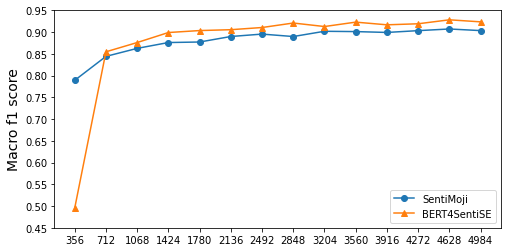

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

temp_fig = temp[['training_set', 'f1_macro_moji', 'f1_macro_bert']].set_index('training_set') 
ax = temp_fig['f1_macro_moji'].plot.line(ax=ax, linestyle='-', marker='o')
ax = temp_fig['f1_macro_bert'].plot.line(ax=ax, linestyle='-', marker='^')
ax.set_xticks(temp['training_set'])
ax.set_yticks(np.arange(min(ax.get_yticks())+0.05, max(ax.get_yticks()), 0.05))
ax.legend(['SentiMoji', 'BERT4SentiSE'],loc='lower right')
ax.set_xlabel('')
ax.set_ylabel('Macro f1 score', fontsize=14)

plt.savefig(fig_dir+'/github_learning_curve'+FIG_EXT, bbox_inches='tight')

In [ ]:
def draw_curve(file_name, itr_count):
  so_moji = pd.read_csv(moji_dir + file_name)
  so_bert = pd.read_csv(bert_dir + file_name)
  temp = so_moji[columns].join(so_bert[columns], lsuffix='_moji', rsuffix='_bert')
  temp['training_set'] = temp['iteration_moji'] * itr_count
  temp_fig = temp[['training_set', 'f1_macro_moji', 'f1_macro_bert']].set_index('training_set') 
  fig, ax = plt.subplots(figsize=(8,3.5))
  ax = temp_fig['f1_macro_moji'].plot.line(ax=ax, linestyle='-', marker='o')
  ax = temp_fig['f1_macro_bert'].plot.line(ax=ax, linestyle='-', marker='^')
  ax.set_xticks(temp['training_set'])
  ax.set_yticks(np.arange(min(ax.get_yticks()), max(ax.get_yticks()), 0.05))
  ax.legend(['SentiMoji', 'BERT4SentiSE'],loc='lower right')
  ax.set_xlabel('')
  ax.set_ylabel('Macro f1 score', fontsize=14)

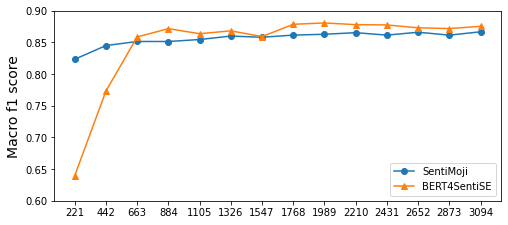

In [ ]:
draw_curve(file_so, itr_so)
plt.savefig(fig_dir+'/so_learning_curve'+FIG_EXT, bbox_inches='tight')

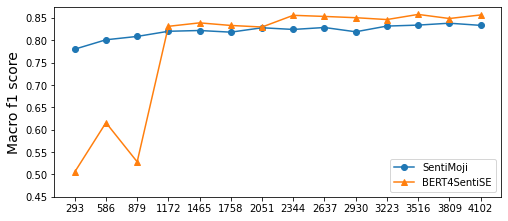

In [ ]:
draw_curve(file_jira, itr_jira)
plt.savefig(fig_dir+'/jira_learning_curve'+FIG_EXT, bbox_inches='tight')